# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

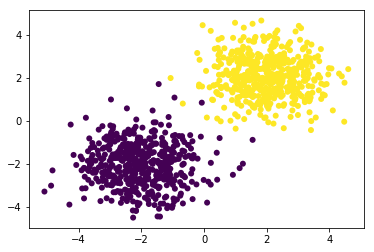

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

criterion = ClassNLLCriterion()



# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

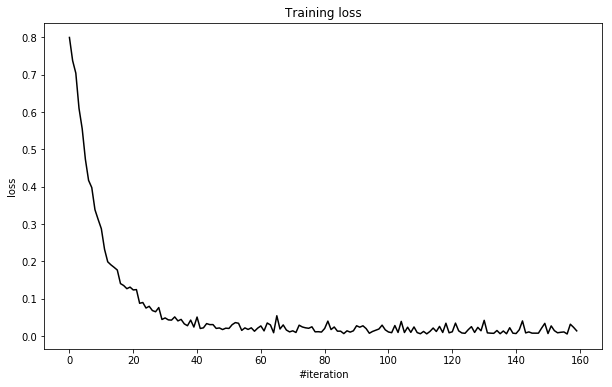

Current loss: 0.013768


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'k')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

In [10]:
y_train_enc = ohe.fit_transform(y_train.reshape(-1, 1))
y_test_enc = ohe.transform(y_test.reshape(-1, 1))

/Users/serega/anaconda3/envs/ds/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
X_train = X_train.reshape(-1, 28*28,)
X_test = X_test.reshape(-1, 28*28,)

In [12]:
X_train.shape, y_train_enc.shape, X_test.shape, y_test_enc.shape

((50000, 784), (50000, 10), (10000, 784), (10000, 10))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [13]:
# Your code goes here. ################################################
def get_2l_zoo(with_bn=False, activations=None):
    net_zoo = {}
    activations = [ReLU, ELU, LeakyReLU, SoftPlus] if activations is None else activations
    for activ in activations:
        net = Sequential()
        net.add(Linear(784, 200))
        if with_bn:
            net.add(BatchNormalization(alpha=0.9))
            net.add(ChannelwiseScaling(200))
        net.add(activ())
        net.add(Linear(200, 10))
        net.add(LogSoftMax())
        net.train()
        name = f'{repr(activ())}{"_bn" if with_bn else ""}'
        net_zoo[name] = net
    return net_zoo

In [14]:
def train_zoo(model_zoo, X_train, y_train, n_epoch=3, batch_size=200, opt='sgd_momentum', config=None,
             lr_decay = 1):
    if opt == 'sgd_momentum':
        optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9} \
                                if config is None else config
        optimizer = sgd_momentum
    elif opt == 'adam':
        optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8} \
                                if config is None else config
        optimizer = adam_optimizer
    else:
        assert False, f'Optimizer {opt} unrecognized.'
    criterion = ClassNLLCriterion()
    # Training all the networks simultaneously
    losses = {kind: [] for kind in model_zoo}
    optimizer_sgd_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
    optimizer_states = {kind: {} for kind in model_zoo}

    for i in range(n_epoch):
        print(f'___Epoch {i+1}___')
        for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
            for kind, net in model_zoo.items():
                net.zeroGradParameters()


            for kind, net in model_zoo.items():
                # Forward
                predictions = net.forward(x_batch)
                loss = criterion.forward(predictions, y_batch)
                # Backward
                dp = criterion.backward(predictions, y_batch)
                net.backward(x_batch, dp)
                # Gradient step
                optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_states[kind])
                losses[kind].append(loss)
        # Learning rate decay
        if (i+1)%10 == 0:
            optimizer_config['learning_rate'] *= lr_decay
        actual_losses = '\n'.join(f'{k}: {np.min(v)}' for k, v in losses.items())
        print(f'losses: \n{actual_losses}')
    return losses

In [15]:
net_zoo = get_2l_zoo()

In [16]:
batched = get_2l_zoo(True, [ReLU])

In [17]:
net_zoo.update(batched)

In [18]:
losses = train_zoo(net_zoo, X_train, y_test_enc, opt='sgd_momentum')

___Epoch 1___
losses: 
ReLU: 1.655106133477945
ELU: 1.381507034304642
LeakyReLU: 1.6408094671256606
SoftPlus: 1.9898713432732467
ReLU_bn: 2.258810777785103
___Epoch 2___
losses: 
ReLU: 0.8942519661362128
ELU: 0.7400622136837004
LeakyReLU: 0.8757277636862375
SoftPlus: 1.495918427170686
ReLU_bn: 2.179114046342043
___Epoch 3___
losses: 
ReLU: 0.6414066027352056
ELU: 0.5731058374189943
LeakyReLU: 0.6359666106669397
SoftPlus: 1.048561058478588
ReLU_bn: 2.019335308258081


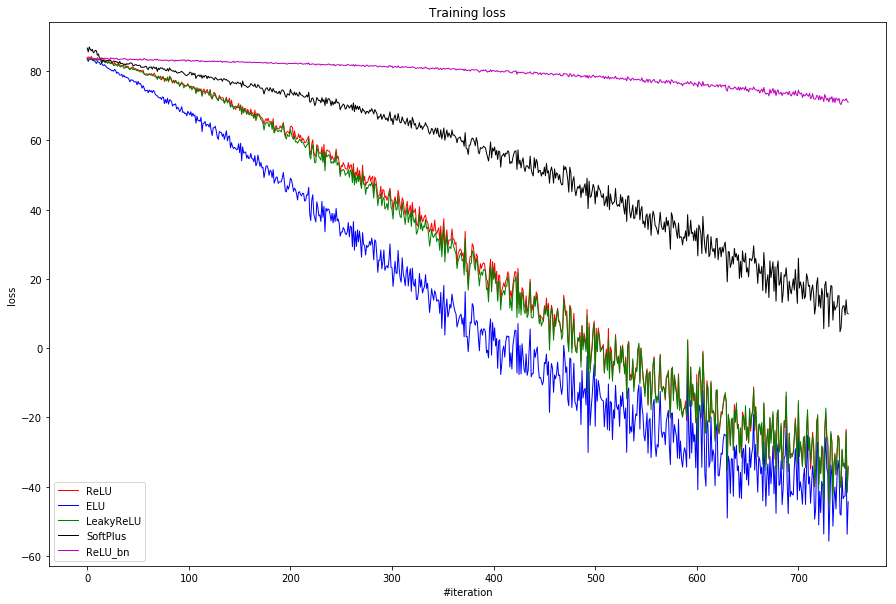

Actual losses: 
ReLU: 0.6414066027352056
ELU: 0.5731058374189943
LeakyReLU: 0.6359666106669397
SoftPlus: 1.048561058478588
ReLU_bn: 2.019335308258081


In [19]:
# Plotting    
plt.figure(figsize=(15, 10))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(100*np.log(losses['ReLU']), 'r', linewidth=1, label='ReLU')
plt.plot(100*np.log(losses['ELU']), 'b', linewidth=1, label='ELU')
plt.plot(100*np.log(losses['LeakyReLU']), 'g', linewidth=1, label='LeakyReLU')
plt.plot(100*np.log(losses['SoftPlus']), 'k', linewidth=1 ,label='SoftPlus')
plt.plot(100*np.log(losses['ReLU_bn']), 'm', linewidth=1, label='ReLU_bn')
plt.legend()
plt.show()
actual_losses = '\n'.join(f'{k}: {np.min(v)}' for k, v in losses.items())
print(f'Actual losses: \n{actual_losses}')

In [20]:
net = get_2l_zoo(False, [ReLU])
loss_sgd = train_zoo(net, X_train, y_test_enc, n_epoch=10, opt='sgd_momentum')
net = get_2l_zoo(False, [ReLU])
loss_adam = train_zoo(net,  X_train, y_test_enc, n_epoch=10, opt='adam')
losses_opt = {**loss_sgd, **loss_adam}

___Epoch 1___
losses: 
ReLU: 1.6826275085714462
___Epoch 2___
losses: 
ReLU: 0.9605842039232063
___Epoch 3___
losses: 
ReLU: 0.6365740869889218
___Epoch 4___
losses: 
ReLU: 0.4879689128548829
___Epoch 5___
losses: 
ReLU: 0.4340741815166019
___Epoch 6___
losses: 
ReLU: 0.36125298551936313
___Epoch 7___
losses: 
ReLU: 0.34288845113332206
___Epoch 8___
losses: 
ReLU: 0.2963141372399763
___Epoch 9___
losses: 
ReLU: 0.2741892455324672
___Epoch 10___
losses: 
ReLU: 0.261125301003472
___Epoch 1___
losses: 
ReLU: 0.14549330200447327
___Epoch 2___
losses: 
ReLU: 0.10188468915890475
___Epoch 3___
losses: 
ReLU: 0.0721066436965498
___Epoch 4___
losses: 
ReLU: 0.04803208373187401
___Epoch 5___
losses: 
ReLU: 0.03817891111043756
___Epoch 6___
losses: 
ReLU: 0.030107417498401956
___Epoch 7___
losses: 
ReLU: 0.020407056861356587
___Epoch 8___
losses: 
ReLU: 0.016732710670038006
___Epoch 9___
losses: 
ReLU: 0.016732710670038006
___Epoch 10___
losses: 
ReLU: 0.01073120699091569


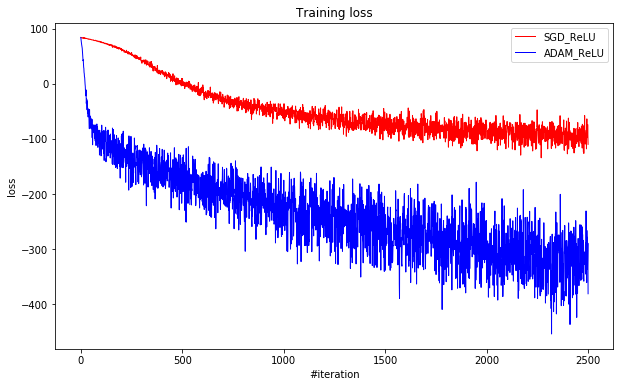

Actual losses:
SGD momentum:0.261125301003472
Adam:0.01073120699091569


In [21]:
plt.figure(figsize=(10, 6))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(100*np.log(loss_sgd['ReLU']), 'r', linewidth=1, label='SGD_ReLU')
plt.plot(100*np.log(loss_adam['ReLU']), 'b', linewidth=1, label='ADAM_ReLU')
plt.legend()
plt.show()
print(f'Actual losses:')
print(f'SGD momentum:{np.min(loss_sgd["ReLU"])}')
print(f'Adam:{np.min(loss_adam["ReLU"])}')

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [22]:
# Your code goes here. ################################################
super_net = Sequential()

super_net.add(Linear(784, 392))
super_net.add(BatchNormalization(alpha=0.9))
super_net.add(ChannelwiseScaling(392))
super_net.add(ReLU())
super_net.add(Dropout(p=0.6))

super_net.add(Linear(392, 196))
super_net.add(BatchNormalization(alpha=0.9))
super_net.add(ChannelwiseScaling(196))
super_net.add(ReLU())
super_net.add(Dropout(p=0.6))

super_net.add(Linear(196, 10))
super_net.add(LogSoftMax())

In [23]:
super_net.train()

In [24]:
loss = train_zoo({'net': super_net}, X_train, y_train_enc, n_epoch=30, opt='adam', lr_decay=0.3)

___Epoch 1___
losses: 
net: 0.22702044362447665
___Epoch 2___
losses: 
net: 0.10633799006402579
___Epoch 3___
losses: 
net: 0.09396663664539197
___Epoch 4___
losses: 
net: 0.06534376496910262
___Epoch 5___
losses: 
net: 0.06534376496910262
___Epoch 6___
losses: 
net: 0.0494598833965236
___Epoch 7___
losses: 
net: 0.0494598833965236
___Epoch 8___
losses: 
net: 0.04343821974752112
___Epoch 9___
losses: 
net: 0.040496359599753264
___Epoch 10___
losses: 
net: 0.030955855130242
___Epoch 11___
losses: 
net: 0.030955855130242
___Epoch 12___
losses: 
net: 0.019626570288479885
___Epoch 13___
losses: 
net: 0.018758727714845484
___Epoch 14___
losses: 
net: 0.018758727714845484
___Epoch 15___
losses: 
net: 0.018758727714845484
___Epoch 16___
losses: 
net: 0.018042054349780703
___Epoch 17___
losses: 
net: 0.014824283031801682
___Epoch 18___
losses: 
net: 0.010356927975929815
___Epoch 19___
losses: 
net: 0.010356927975929815
___Epoch 20___
losses: 
net: 0.010356927975929815
___Epoch 21___
losses: 
n

Print here your accuracy on test set. It should be around 90%.

In [25]:
super_net.evaluate()

In [26]:
y_pred = super_net.forward(X_test)

In [27]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [28]:
acc = np.sum(y_pred_labels == y_test)/len(y_pred_labels)
acc

0.982